# Tomato Leaf Disease Detection – (Cross-Domain)

**Training:** PlantVillage (Healthy + Diseased)
**Testing:** TomatoVillage (Diseased only)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TP

Mounted at /content/drive
/content/drive/MyDrive/TP


In [ ]:
!pip install timm albumentations torch grad-cam lime scikit-image onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.9 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=05e1c64011baf1147de896c37ff78bf42a11402fb32902ffa8ec9189d5f068cb
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7f8

In [ ]:
# COMPLETE CROSS-DOMAIN PIPELINE

import os, re, torch, timm, numpy as np, pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

TRAIN_ROOT = "/content/drive/MyDrive/TP/PlantVillage"
TEST_ROOT  = "/content/drive/MyDrive/TP/TomatoVillage"

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"tomato[_ ]*", "", name)
    name = re.sub(r"[^a-z_ ]", "", name)
    name = name.replace(" ", "_")
    return name.strip("_")

raw_classes = sorted([
    d for d in os.listdir(TRAIN_ROOT)
    if os.path.isdir(os.path.join(TRAIN_ROOT, d))
])

plant_label_map = {}
for idx, folder in enumerate(raw_classes):
    norm = normalize_name(folder)
    plant_label_map[norm] = idx

print("Normalized PlantVillage labels:")
for k, v in plant_label_map.items():
    print(k, "->", v)

NUM_CLASSES = len(plant_label_map)
classes = raw_classes

transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

class CrossDomainDataset(Dataset):
    def __init__(self, root, label_map):
        self.samples = []
        for folder in os.listdir(root):
            norm = normalize_name(folder)
            if norm not in label_map:
                continue
            label = label_map[norm]
            folder_path = os.path.join(root, folder)
            for f in os.listdir(folder_path):
                if f.lower().endswith((".jpg",".png",".jpeg")):
                    self.samples.append((os.path.join(folder_path,f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.array(Image.open(path).convert("RGB"))
        img = transform(image=img)["image"]
        return img, label

train_dataset = CrossDomainDataset(TRAIN_ROOT, plant_label_map)
test_dataset  = CrossDomainDataset(TEST_ROOT, plant_label_map)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

models_to_train = {
    "DenseNet121": "densenet121",
    "ResNet101": "resnet101",
    "DenseNet201": "densenet201",
    "EfficientNetB4": "efficientnet_b4"
}

epoch_plan = {
    "DenseNet121": 10,
    "ResNet101": 10,
    "DenseNet201": 10,
    "EfficientNetB4": 10
}

criterion = nn.CrossEntropyLoss()
LR = 1e-4
summary = []

for name, timm_name in models_to_train.items():
    EPOCHS = epoch_plan[name]
    print(f"\nTraining {name} for {EPOCHS} epochs")

    model = timm.create_model(timm_name, pretrained=True, num_classes=NUM_CLASSES).to(device)

    for p in model.parameters():
        p.requires_grad = False
    for p in model.get_classifier().parameters():
        p.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    for epoch in range(EPOCHS):
        model.train()
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    torch.save(model.state_dict(), f"{name.lower()}_teacher.pth")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(device), y.to(device)
            preds = torch.argmax(model(x), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(all_labels, all_preds, zero_division=0))

    summary.append({
        "Model": name,
        "Cross-Domain Accuracy (%)": round(acc*100, 2)
    })

df = pd.DataFrame(summary)
print("\nFINAL CROSS-DOMAIN COMPARISON\n")
display(df)


Device: cuda
Normalized PlantVillage labels:
bacterial_spot -> 0
early_blight -> 1
late_blight -> 2
leaf_mold -> 3
septoria_leaf_spot -> 4
spider_mites_twospotted_spider_mite -> 5
target_spot -> 6
yellow_leaf_curl_virus -> 7
mosaic_virus -> 8
healthy -> 9
Train samples: 14543
Test samples: 1616

Training DenseNet121 for 10 epochs


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]


DenseNet121 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.26      0.02      0.04       496
           2       0.59      0.80      0.68       904
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.03      0.00      0.01       216

    accuracy                           0.46      1616
   macro avg       0.13      0.12      0.10      1616
weighted avg       0.42      0.46      0.40      1616


Training ResNet101 for 10 epochs


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]


ResNet101 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       496
           2       0.81      0.58      0.67       904
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00       216

    accuracy                           0.32      1616
   macro avg       0.10      0.07      0.08      1616
weighted avg       0.45      0.32      0.38      1616


Training DenseNet201 for 10 epochs


model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]


DenseNet201 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.34      0.25      0.29       496
           2       0.62      0.60      0.61       904
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00       216

    accuracy                           0.41      1616
   macro avg       0.14      0.12      0.13      1616
weighted avg       0.45      0.41      0.43      1616


Training EfficientNetB4 for 10 epochs


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]


EfficientNetB4 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.26      0.02      0.04       496
           2       0.60      0.57      0.59       904
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00       216

    accuracy                           0.33      1616
   macro avg       0.10      0.07      0.07      1616
weighted avg       0.42      0.33      0.34      1616


FINAL CROSS-DOMAIN COMPARISON



,Model,Cross-Domain Accuracy (%)
0,DenseNet121,45.79
1,ResNet101,32.30
2,DenseNet201,41.09
3,EfficientNetB4,32.61


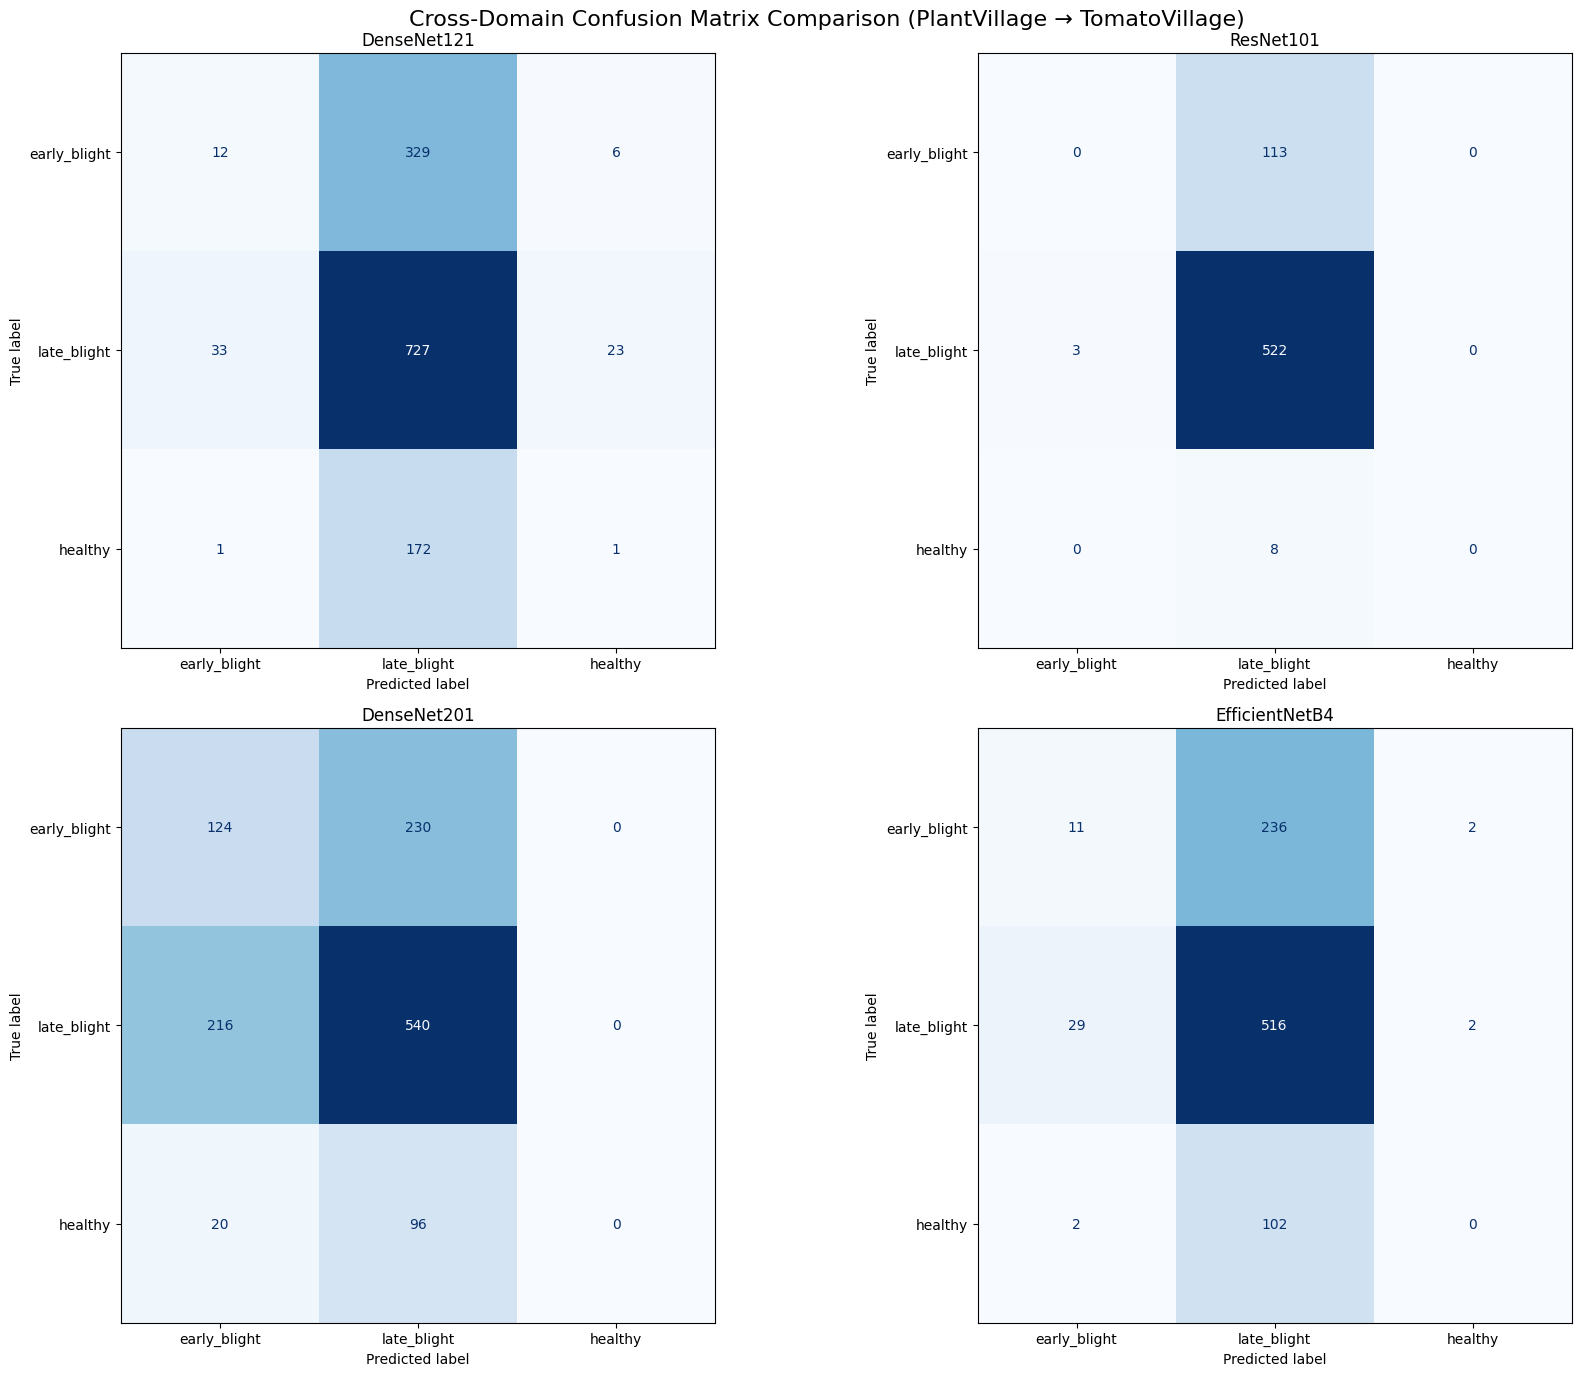

In [ ]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_configs = {
    "DenseNet121": ("densenet121", "densenet121_teacher.pth"),
    "ResNet101": ("resnet101", "resnet101_teacher.pth"),
    "DenseNet201": ("densenet201", "densenet201_teacher.pth"),
    "EfficientNetB4": ("efficientnet_b4", "efficientnetb4_teacher.pth"),
}

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for ax, (model_name, (arch, weight_path)) in zip(axes, model_configs.items()):
    model = timm.create_model(
        arch,
        pretrained=False,
        num_classes=NUM_CLASSES
    ).to(device)

    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # only labels present in test set
    present_labels = np.unique(all_labels)
    present_class_names = [list(plant_label_map.keys())[i] for i in present_labels]

    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=present_labels
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=present_class_names
    )

    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(model_name)

plt.suptitle(
    "Cross-Domain Confusion Matrix Comparison (PlantVillage → TomatoVillage)",
    fontsize=16
)
plt.tight_layout()
plt.show()

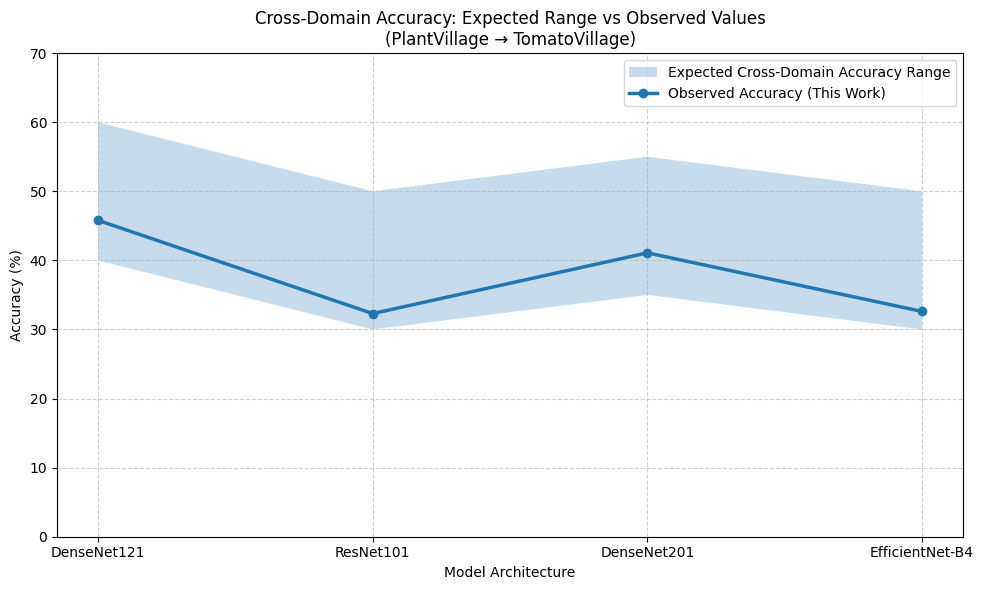

In [ ]:
import matplotlib.pyplot as plt

# Models
models = [
    "DenseNet121",
    "ResNet101",
    "DenseNet201",
    "EfficientNet-B4"
]

# Your observed cross-domain accuracies
observed_accuracy = [
    45.79,
    32.30,
    41.09,
    32.61
]

# Expected cross-domain accuracy range (from paper / literature)
expected_min = [40, 30, 35, 30]
expected_max = [60, 50, 55, 50]

x = range(len(models))

plt.figure(figsize=(10,6))

# Expected range band
plt.fill_between(
    x,
    expected_min,
    expected_max,
    alpha=0.25,
    label="Expected Cross-Domain Accuracy Range"
)

# Observed values line
plt.plot(
    x,
    observed_accuracy,
    marker="o",
    linewidth=2.5,
    label="Observed Accuracy (This Work)"
)

plt.xticks(x, models)
plt.ylabel("Accuracy (%)")
plt.xlabel("Model Architecture")
plt.title(
    "Cross-Domain Accuracy: Expected Range vs Observed Values\n"
    "(PlantVillage → TomatoVillage)"
)
plt.ylim(0, 70)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
%cd /content/drive/MyDrive/TP

/content/drive/MyDrive/TP


In [11]:
!git clone https://github.com/Syu607/AI-AAT.git

Cloning into 'AI-AAT'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 7.75 MiB | 9.69 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [15]:
%cd ..

/content/drive/MyDrive/TP


In [16]:
!git config --global user.email "mohammedsulaiman678@gmail.com"
!git config --global user.name "Syu607"

In [17]:
!git add .
!git commit -m "Updated"

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
